In [2]:
#%%
#載入套件
import pandas as pd
pd.set_option("display.max_rows", None, "display.max_columns", None)
import numpy as np
np.set_printoptions(precision=3, suppress=True)
import seaborn as sns
sns.set(style='whitegrid')
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from keras import layers
from keras import regularizers
from keras import preprocessing
from sklearn.model_selection import train_test_split, RepeatedStratifiedKFold, cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_curve, roc_auc_score, confusion_matrix, precision_recall_curve, auc
from sklearn.feature_selection import f_classif
from sklearn.pipeline import Pipeline
from sklearn.base import BaseEstimator, TransformerMixin
from scipy.stats import chi2_contingency
import math
import uuid
import random
import zipfile
import pandas as pd
from sklearn.preprocessing import MinMaxScaler

In [3]:
#%%
# 分割x and y
def split_x_y(data_train,data_test,target="kredit"):

  train_y = data_train[target]
  train_x = data_train.drop(target, axis=1)

  test_x = data_test.drop(target, axis=1)
  test_y = data_test[target]

  return train_x, train_y, test_x, test_y

# 
def add_id(original_df):
  id = pd.Series(range(0,1000)).apply(lambda i : str(uuid.uuid4()))
  df_with_id = original_df.copy()
  df_with_id['id'] = id
  df_with_id = df_with_id.set_index('id')

  return df_with_id

def split_columns(df_with_id,columns_list,target):
  colum_1 = columns_list.copy()
  colum_1.append(target)
  colum_2 = columns_list.copy()
  # 分割欄位
  client1_data = df_with_id[colum_1]
  client2_data = df_with_id.drop(colum_2, axis=1)

  # 切割資料
  client1_train, client1_test = train_test_split(client1_data, test_size=0.2, random_state=0)
  client2_train, client2_test = train_test_split(client2_data, test_size=0.2, random_state=0)


  # 切割x,y
  client1_train_x,client1_train_y, client1_test_x, client1_test_y = split_x_y(client1_train,client1_test,target)
  client2_train_x,client2_train_y, client2_test_x, client2_test_y = split_x_y(client2_train,client2_test,target)

  # 找出共同的index
  common_train_index = client1_train.index.intersection(client2_train.index)
  common_test_index = client1_test.index.intersection(client2_test.index)

  return client1_train_x,client1_train_y, client1_test_x, client1_test_y, client2_train_x,client2_train_y, client2_test_x, client2_test_y, common_train_index, common_test_index
#%%
# model
# normalize data
def normalize_data(data):
  normalizer = tf.keras.layers.Normalization()
  normalizer.adapt(np.array(data))
  return normalizer
#%%
#client
class Client:

  def __init__(self, train_data_x,train_data_y, test_data_x,test_data_y, labelled,model):
    self.__trainX = train_data_x.copy()
    self.__testX = test_data_x.copy()
    self.labelled = labelled
    self.__trainY = train_data_y.copy()
    self.__testY = test_data_y.copy()
    self.model = model
    
  def next_batch(self, index):
    self.batchX = self.__trainX.loc[index]

    if not self.labelled:
      grads = []
      self.model_output = np.zeros((len(index), 2))
      for i in range(len(index)):
        with tf.GradientTape() as gt:
          gt.watch(self.model.trainable_weights)
          output_by_example = self.model(self.batchX.iloc[i:i+1], training=True)
          output_for_grad = output_by_example[:,1]
        self.model_output[i] = output_by_example
        grads.append(gt.gradient(output_for_grad, self.model.trainable_weights))

      return grads
    
    else:
      self.batchY = self.__trainY.loc[index]
      with tf.GradientTape() as self.gt:
        self.gt.watch(self.model.trainable_weights)
        self.model_output = self.model(self.batchX, training=True)
  def cal_model(self):
    return self.model_output
  
  def predict(self, test_index):
    return self.model.predict(self.__testX.loc[test_index])# + 1e-8

  def predict_all(self, index):
    return self.model.predict(pd.concat([self.__trainX, self.__testX]).loc[index])

  def test_answers(self, test_index):
    if self.labelled:
      return self.__testY.loc[test_index]
    
  def test_answers_all(self, index):
    if self.labelled:
      return pd.concat([self.__testY, self.__trainY]).loc[index]
  
  def batch_answers(self):
    if self.labelled:
      return self.batchY

  def loss_and_update(self, a):
    if not self.labelled:
      raise AssertionError("This method can only be called by client 2")
    self.prob = (a + self.model_output)/2
    self.c = self.coefficient_and_update()/len(self.batchX)
    return self.prob, loss_fn(self.batchY, self.prob)
  
  def coefficient_and_update(self):
    if not self.labelled:
      raise AssertionError("This method can only be called by client 2")
    p = self.prob[:,1]
    c = (p-self.batchY)/((p)*(1-p))
    with self.gt:
      output = sum(c * self.model_output[:,1])/len(c)
    grads = self.gt.gradient(output, self.model.trainable_weights)
    optimizer.apply_gradients(zip(grads, self.model.trainable_weights))
    return c
  
  def update_with(self, grads):
    optimizer.apply_gradients(zip(grads, self.model.trainable_weights))

  def assemble_grad(self, partial_grads):
    if not self.labelled:
      raise AssertionError("This method can only be called by client 2")
    # to assemble the gradient for client 1
    for i in range(len(self.c)):
      partial_grads[i] = [x * self.c[i] for x in partial_grads[i]]
    return [sum(x) for x in zip(*partial_grads)]
# 畫圖
# roc curve
def draw_roc_curve(fpr, tpr,auc):
  fig, ax = plt.subplots()
  plt.title('Receiver Operating Characteristic')
  plt.plot(fpr, tpr, color = 'orange', label = 'AUC = %0.2f' % auc)
  plt.legend(loc = 'lower right')
  plt.plot([0, 1], [0, 1],'r--')
  plt.xlim([0, 1])
  plt.ylim([0, 1])
  plt.ylabel('True Positive Rate')
  plt.xlabel('False Positive Rate')
  plt.show()  


# 訓練圖
def plot_loss(loss, accuracy):
  fig, ax = plt.subplots()
  plt.plot(loss, label='loss')
  plt.plot(accuracy, label='accuracy')
  plt.xlabel('Epoch')
  # plt.ylabel('Error')
  plt.legend()
  plt.grid(True)

# 準確率圖
def plot_accuracy(predictions, answers, threshold):
  tp, tn, fp, fn = 0, 0, 0, 0

  for x in range(len(predictions)):
    if answers[x] == 1:
      # if np.argmax(predictions[x]) == 1:
      if predictions[x][1] >= threshold:
        tp = tp + 1
      else:
        fn = fn + 1
    else:
      # if np.argmax(predictions[x]) == 0:
      if predictions[x][1] < threshold:
        tn = tn + 1
      else:
        fp = fp + 1
  
  accuracy = (tp + tn)/(tp + fp + fn + tn)
  precision = tp / (tp + fp)
  recall = tp / (tp + fn)
  specificity = tn / (tn + fp)
  print("Accuracy: " + str(accuracy))
  print("Precision: " + str(precision))
  print("Recall: " + str(recall))
  # print("Specificity: " + str(specificity))
  print("F-Measure: " + str(2*(recall * precision) / (recall + precision)))

In [4]:
# %%
# 清理資料

original_df = pd.read_csv('/content/train.csv')

original_df.describe()


# Drop irrelevant columns
original_df.drop(['PassengerId', 'Name', 'Ticket', 'Cabin'], axis=1, inplace=True)

# Fill missing values in the 'Age' column
median_age = original_df['Age'].median()
original_df['Age'].fillna(median_age, inplace=True)

# Fill missing values in the 'Embarked' column
most_common_embarked = original_df['Embarked'].value_counts().index[0]
original_df['Embarked'].fillna(most_common_embarked, inplace=True)

# Convert categorical variables to numeric variables
original_df['Sex'] = original_df['Sex'].map({'male': 0, 'female': 1})
original_df['Embarked'] = original_df['Embarked'].map({'S': 0, 'C': 1, 'Q': 2})

# Create a new column 'FamilySize'
original_df['FamilySize'] = original_df['SibSp'] + original_df['Parch'] + 1

# Drop the 'SibSp' and 'Parch' columns
original_df.drop(['SibSp', 'Parch'], axis=1, inplace=True)



# Normalize all columns
scaler = MinMaxScaler()
df_norm = scaler.fit_transform(original_df)
original_df =pd.DataFrame(df_norm,columns=original_df.columns)


# 添加id
df_with_id = add_id(original_df)

# 切割資料
target='Survived'
columns_list = ['Pclass', 'Sex', 'Age']
client1_train_x,client1_train_y, client1_test_x, client1_test_y, client2_train_x,client2_train_y, client2_test_x, client2_test_y, common_train_index, common_test_index = split_columns(df_with_id,columns_list=columns_list,target=target)
# 顯示訓練測試資料大小
print(
    'There are {} common entries (out of {}) in client 1 and client 2\'s training datasets,\nand {} common entries (out of {}) in their test datasets'
    .format(
        len(common_train_index),
        len(client1_train_x),
        len(common_test_index),
        len(client1_test_x)))

There are 712 common entries (out of 712) in client 1 and client 2's training datasets,
and 179 common entries (out of 179) in their test datasets


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 normalization (Normalizatio  (None, 3)                7         
 n)                                                              
                                                                 
 dense (Dense)               (None, 128)               512       
                                                                 
 dropout (Dropout)           (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 128)               16512     
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                                 
 dense_2 (Dense)             (None, 2)                 258       
                                                        

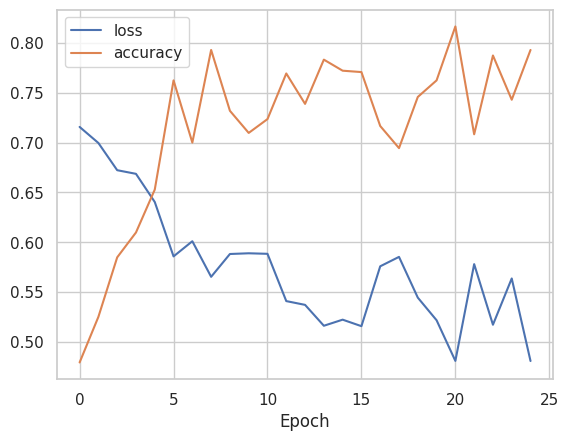

In [5]:
#
# %%
#vfl
# 設定參數
batch_size = 90
learning_rate = 0.5e-4
epochs = 25

# Instantiate an optimizer.
optimizer=tf.keras.optimizers.legacy.Adam(learning_rate=learning_rate)
# Instantiate a loss function.
# Not from logits because of the softmax layer converting logits to probability.
loss_fn = keras.losses.SparseCategoricalCrossentropy(from_logits=False)
# Instantiate a metric function (accuracy)
train_acc_metric = tf.keras.metrics.SparseCategoricalAccuracy()
#%%
# init client
normalizer1 = normalize_data(client1_train_x.loc[common_train_index])
model1 =   tf.keras.Sequential([
      normalizer1,
      layers.Dense(128, activation='elu', kernel_regularizer=regularizers.l2(0.01)),
      layers.Dropout(0.5),
      layers.Dense(128, activation='elu', kernel_regularizer=regularizers.l2(0.01)),
      layers.Dropout(0.5),
      layers.Dense(2),
      layers.Softmax()])
model1.summary()
client1 = Client(client1_train_x, client1_train_y,client1_test_x,client1_test_y, False,model1)


normalizer2 = normalize_data(client2_train_x.loc[common_train_index])
model2 = tf.keras.Sequential([
      normalizer2,
      layers.Dense(128, activation='elu', kernel_regularizer=regularizers.l2(0.01)),
      layers.Dropout(0.5),
      layers.Dense(128, activation='elu', kernel_regularizer=regularizers.l2(0.01)),
      layers.Dropout(0.5),
      layers.Dense(2),
      layers.Softmax()])
client2 = Client(client2_train_x, client2_train_y,client2_test_x,client2_test_y, True,model2)

#%%
# train_on_client
common_train_index_list = common_train_index.to_list()
epoch_loss = []
epoch_acc = []

for epoch in range(epochs):
    print(f'run in {epoch} epoch')
    # epoch=0
    random.shuffle(common_train_index_list)
    train_index_batches = [common_train_index_list[i:i + batch_size] for i in range(0, len(common_train_index_list), batch_size)] 
    total_loss = 0.0
    # Iterate over the batches of the dataset.
    for step, batch_index in enumerate(train_index_batches):
        # step =0
        batch_index = train_index_batches[0]
        partial_grads = client1.next_batch(batch_index)
        client2.next_batch(batch_index)
        prob, loss_value = client2.loss_and_update(client1.cal_model())
        grad = client2.assemble_grad(partial_grads)
        client1.update_with(grad)
        
        total_loss = loss_value + total_loss
        train_acc_metric.update_state(client2.batch_answers(), prob)
    train_acc = train_acc_metric.result()
    print(f'-----train accuracy{train_acc}-----loss{(total_loss)/(step + 1)}')
    train_acc_metric.reset_states()
    epoch_loss.append((total_loss)/(step + 1))
    epoch_acc.append(train_acc)

plot_loss(epoch_loss, epoch_acc)



6/6 [==============================] - 0s 3ms/step


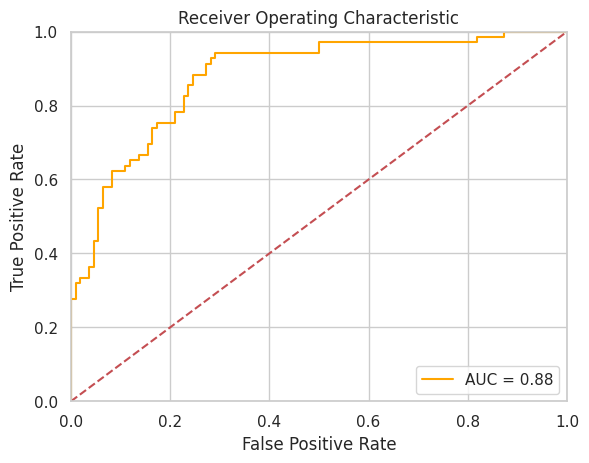

AUC: 0.8785243741765482
Best Threshold=0.309397, G-Mean=0.817

Accuracy: 0.7988826815642458
Precision: 0.6701030927835051
Recall: 0.9420289855072463
F-Measure: 0.7831325301204819


In [6]:
#%%
# 預測結果
vfl_pred_test = (client1.predict(common_test_index) + client2.predict(common_test_index))/2

# 計算roc,auc
vfl_fpr_test, vfl_tpr_test, vfl_thresholds_test = roc_curve(client2.test_answers(common_test_index), vfl_pred_test[:,1])
auc1 = auc(vfl_fpr_test, vfl_tpr_test)
draw_roc_curve(vfl_fpr_test, vfl_tpr_test,auc1)
print("AUC: {}".format(auc1 ))

# 計算threshold 值
vfl_gmeans_test = np.sqrt(vfl_tpr_test * (1-vfl_fpr_test))
vfl_ix_test = np.argmax(vfl_gmeans_test)
best_threshold = vfl_thresholds_test[vfl_ix_test]
print('Best Threshold=%f, G-Mean=%.3f\n' % (vfl_thresholds_test[vfl_ix_test], vfl_gmeans_test[vfl_ix_test]))

# 準確率
plot_accuracy(vfl_pred_test, client2.test_answers(common_test_index), best_threshold)

# save result
df=pd.DataFrame(client2.test_answers(common_test_index))
vfl_pred_test_label = [1 if p >= best_threshold else 0 for p in  vfl_pred_test[:,1]]
df['predict']=vfl_pred_test_label
df.to_csv('vfl_cen_predict.csv',encoding ='UTF-8-sig')
#evalueate



Epoch 1: Loss=1.7170, Accuracy=0.7725
Epoch 2: Loss=1.4420, Accuracy=0.7767
Epoch 3: Loss=1.2248, Accuracy=0.7795
Epoch 4: Loss=1.0718, Accuracy=0.7795
Epoch 5: Loss=0.9593, Accuracy=0.7851
Epoch 6: Loss=0.8577, Accuracy=0.7879
Epoch 7: Loss=0.7760, Accuracy=0.7851
Epoch 8: Loss=0.7321, Accuracy=0.7893
Epoch 9: Loss=0.6917, Accuracy=0.7851
Epoch 10: Loss=0.6679, Accuracy=0.7781
Epoch 11: Loss=0.6388, Accuracy=0.7879
Epoch 12: Loss=0.6175, Accuracy=0.7823
Epoch 13: Loss=0.5977, Accuracy=0.7893
Epoch 14: Loss=0.5830, Accuracy=0.7865
Epoch 15: Loss=0.5720, Accuracy=0.7879
Epoch 16: Loss=0.5577, Accuracy=0.7837
Epoch 17: Loss=0.5474, Accuracy=0.7978
Epoch 18: Loss=0.5353, Accuracy=0.7893
Epoch 19: Loss=0.5328, Accuracy=0.7893
Epoch 20: Loss=0.5242, Accuracy=0.7935
6/6 - 0s - loss: 0.4814 - accuracy: 0.7989 - 212ms/epoch - 35ms/step

Test accuracy: 0.7988826632499695
6/6 [==============================] - 0s 3ms/step


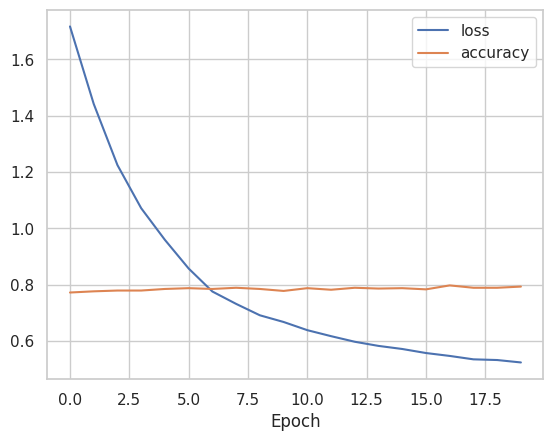

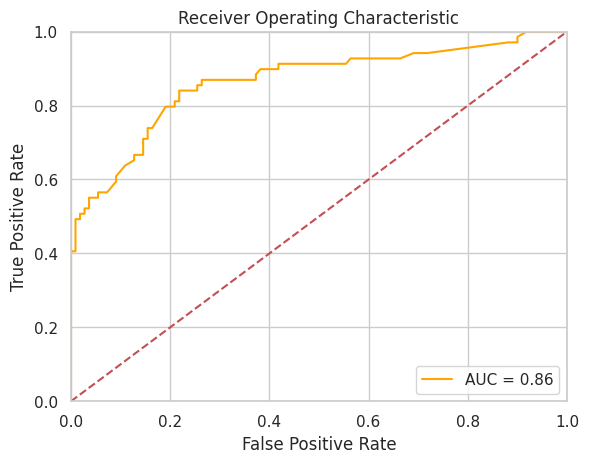

AUC: 0.8785243741765482
Best Threshold=0.409371, G-Mean=0.811

Accuracy: 0.8044692737430168
Precision: 0.7073170731707317
Recall: 0.8405797101449275
F-Measure: 0.7682119205298014


In [7]:
#%%

# ----------------------------------centralized----------------------------
#%%
#%% 

# 設定參數
batch_size = 32
learning_rate = 1e-3
epochs = 20

# Instantiate a metric function (accuracy)
train_acc_metric = tf.keras.metrics.SparseCategoricalAccuracy()

#%%
# init cen_1
normalizer_cen1 = normalize_data(client1_train_x.loc[common_train_index])
model_cen1 = model_cen1 = tf.keras.Sequential([
      normalizer_cen1,
      layers.Dense(128, activation='elu', kernel_regularizer=regularizers.l2(0.01)),
      layers.Dropout(0.5),
      layers.Dense(128, activation='elu', kernel_regularizer=regularizers.l2(0.01)),
      layers.Dropout(0.5),
      layers.Dense(2),
      layers.Softmax()])


epoch_loss=[]
epoch_acc=[]
# custom callback
class PrintMetricsCallback(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs=None):
        epoch_loss.append(logs["loss"])
        epoch_acc.append(logs["accuracy"])
        print(f'Epoch {epoch+1}: Loss={logs["loss"]:.4f}, Accuracy={logs["accuracy"]:.4f}')


model_cen1.compile(optimizer=tf.keras.optimizers.legacy.Adam(learning_rate=learning_rate),
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
              metrics=['accuracy'])



# fit1
test_results = {}
cen1_history = model_cen1.fit(client1_train_x, client1_train_y, epochs=epochs, verbose=0, batch_size=batch_size, callbacks=[PrintMetricsCallback()])


#evaluate
test_loss, test_acc = model_cen1.evaluate(client1_test_x, client1_test_y, verbose=2)
print('\nTest accuracy:', test_acc)


# result
cen1_pred_test= model_cen1.predict(client1_test_x)

# plot loss
plot_loss(epoch_loss, epoch_acc)
# 計算roc,auc
cen1_fpr_test, cen1_tpr_test, cen1_thresholds_test = roc_curve(client1_test_y, cen1_pred_test[:,1])
auc_cen1 = auc(cen1_fpr_test, cen1_tpr_test)
draw_roc_curve(cen1_fpr_test, cen1_tpr_test,auc=auc_cen1)
print("AUC: {}".format(auc1 ))

# 計算threshold 值

cen1_gmeans_test = np.sqrt(cen1_tpr_test * (1-cen1_fpr_test))
cen1_ix_test = np.argmax(cen1_gmeans_test)
best_threshold_cen1 = cen1_thresholds_test[cen1_ix_test]
print('Best Threshold=%f, G-Mean=%.3f\n' % (cen1_thresholds_test[cen1_ix_test], cen1_gmeans_test[cen1_ix_test]))


# probability_model = tf.keras.Sequential([model, tf.keras.layers.Softmax()])

plot_accuracy(cen1_pred_test,client1_test_y,best_threshold_cen1)
cen1_pred_test_label = [1 if p >= best_threshold_cen1 else 0 for p in  cen1_pred_test[:,1]]
df['predict_cen1']=cen1_pred_test_label
df.to_csv('vfl_cen_1_predict.csv',encoding ='UTF-8-sig')



Epoch 1: Loss=1.8856, Accuracy=0.5871
Epoch 2: Loss=1.5909, Accuracy=0.6419
Epoch 3: Loss=1.3792, Accuracy=0.6615
Epoch 4: Loss=1.2215, Accuracy=0.6559
Epoch 5: Loss=1.1003, Accuracy=0.6671
Epoch 6: Loss=1.0255, Accuracy=0.6573
Epoch 7: Loss=0.9540, Accuracy=0.6657
Epoch 8: Loss=0.8984, Accuracy=0.6685
Epoch 9: Loss=0.8500, Accuracy=0.6643
Epoch 10: Loss=0.8207, Accuracy=0.6713
Epoch 11: Loss=0.8013, Accuracy=0.6503
Epoch 12: Loss=0.7706, Accuracy=0.6601
Epoch 13: Loss=0.7432, Accuracy=0.6629
Epoch 14: Loss=0.7361, Accuracy=0.6587
Epoch 15: Loss=0.7251, Accuracy=0.6573
Epoch 16: Loss=0.7107, Accuracy=0.6685
Epoch 17: Loss=0.7049, Accuracy=0.6615
Epoch 18: Loss=0.7001, Accuracy=0.6531
Epoch 19: Loss=0.6846, Accuracy=0.6587
Epoch 20: Loss=0.6856, Accuracy=0.6671
6/6 - 0s - loss: 0.6401 - accuracy: 0.7151 - 258ms/epoch - 43ms/step

Test accuracy: 0.7150837779045105
6/6 [==============================] - 0s 3ms/step


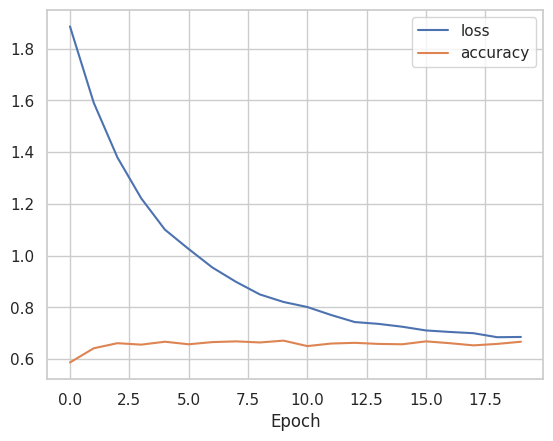

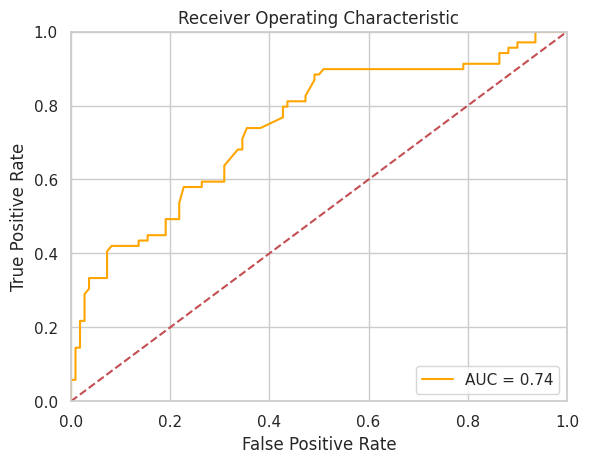

AUC: 0.7427536231884059
Best Threshold=0.295835, G-Mean=1.157

Accuracy: 0.6480446927374302
Precision: 0.5254237288135594
Recall: 0.8985507246376812
F-Measure: 0.663101604278075


In [8]:
#%%
# init cen_2
normalizer_cen2 = normalize_data(client2_train_x.loc[common_train_index])
model_cen2 = tf.keras.Sequential([
      normalizer_cen2,
      layers.Dense(128, activation='elu', kernel_regularizer=regularizers.l2(0.01)),
      layers.Dropout(0.5),
      layers.Dense(128, activation='elu', kernel_regularizer=regularizers.l2(0.01)),
      layers.Dropout(0.5),
      layers.Dense(2),
      layers.Softmax()])

epoch_loss=[]
epoch_acc=[]
# custom callback
class PrintMetricsCallback(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs=None):
        epoch_loss.append(logs["loss"])
        epoch_acc.append(logs["accuracy"])
        print(f'Epoch {epoch+1}: Loss={logs["loss"]:.4f}, Accuracy={logs["accuracy"]:.4f}')


model_cen2.compile(optimizer=tf.keras.optimizers.legacy.Adam(learning_rate=learning_rate),
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
              metrics=['accuracy'])


# fit2
test_results = {}
cen2_history = model_cen2.fit(client2_train_x, client2_train_y, epochs=epochs, verbose=0, batch_size=batch_size, callbacks=[PrintMetricsCallback()])


#evaluate
test_loss, test_acc = model_cen2.evaluate(client2_test_x, client2_test_y, verbose=2)
print('\nTest accuracy:', test_acc)


# result
cen2_pred_test= model_cen2.predict(client2_test_x)

# plot loss
plot_loss(epoch_loss, epoch_acc)

# 計算roc,auc
cen2_fpr_test, cen2_tpr_test, cen2_thresholds_test = roc_curve(client2_test_y, cen2_pred_test[:,1])
auc_cen2 = auc(cen2_fpr_test, cen2_tpr_test)
draw_roc_curve=draw_roc_curve(cen2_fpr_test, cen2_tpr_test,auc=auc_cen2)
print("AUC: {}".format(auc_cen2 ))

# 計算threshold 值

cen2_gmeans_test = np.sqrt(cen2_tpr_test * (2-cen2_fpr_test))
cen2_ix_test = np.argmax(cen2_gmeans_test)
best_threshold_cen2 = cen2_thresholds_test[cen2_ix_test]
print('Best Threshold=%f, G-Mean=%.3f\n' % (cen2_thresholds_test[cen2_ix_test], cen2_gmeans_test[cen2_ix_test]))

# save result
# probability_model = tf.keras.Sequential([model, tf.keras.layers.Softmax()])
plot_accuracy(cen2_pred_test,client2_test_y,best_threshold_cen2)
cen2_pred_test_label = [1 if p >= best_threshold_cen2 else 0 for p in  cen2_pred_test[:,1]]
df['predict_cen2']=cen2_pred_test_label
df.to_csv('vfl_cen_2_predict.csv',encoding ='UTF-8-sig')